In [1]:
import tensorflow as tf
import pandas as pd

from tensorflow.keras.callbacks  import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import os
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image

import ipywidgets as widgets
import io
from IPython.display import clear_output,display


In [2]:
image_path="../input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/train/"

In [3]:
cls_name=os.listdir(image_path)
print(cls_name)

['Final AD JPEG', 'Final LMCI JPEG', 'Final MCI JPEG', 'Final CN JPEG', 'Final EMCI JPEG']


In [4]:
print("Number of classes : {}".format(len(cls_name)))

Number of classes : 5


In [5]:
number_of_images={}
for class_name in cls_name:
    number_of_images[class_name]=len(os.listdir(image_path+"/"+class_name))
images_each_class=pd.DataFrame(number_of_images.values(),index=number_of_images.keys(),columns=["Number of images"])
images_each_class

,Number of images
Final AD JPEG,145
Final LMCI JPEG,61
Final MCI JPEG,198
Final CN JPEG,493
Final EMCI JPEG,204


In [6]:
label_name=["Final AD JPEG","Final CN JPEG","Final EMCI JPEG","Final LMCI JPEG","Final MCI JPEG"]

# train data and test data preprocessing

In [7]:
print("presprocess train data\n")

image_data=[]
label_data=[]
image_size=150

for i in label_name:
    data_path=os.path.join("../input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/","train",i)
    for m in tqdm(os.listdir(data_path)):
        image=cv2.imread(os.path.join(data_path,m))
        image=cv2.resize(image,(image_size,image_size))
        
        image_data.append(image)
        label_data.append(i)

    



for i in label_name:
    data_path=os.path.join("../input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/","test",i)
    for m in tqdm(os.listdir(data_path)):
        image=cv2.imread(os.path.join(data_path,m))
        image=cv2.resize(image,(image_size,image_size))
        
        image_data.append(image)
        label_data.append(i)
        
image_data=np.array(image_data)
label_data=np.array(label_data)

presprocess train data



100%|██████████| 35/35 [00:00<00:00, 442.14it/s]


In [8]:
image_data.shape

(1296, 150, 150, 3)

In [9]:
image_data,label_data=shuffle(image_data,label_data,random_state=42)

In [10]:
X_train,X_test,Y_train,Y_test=train_test_split(image_data,label_data,test_size=0.2,random_state=42)

# apply onehot encoding

In [11]:
train_label_data_new=[]
test_label_data_new=[]
for n in Y_train:
    train_label_data_new.append(label_name.index(n))
Y_train=train_label_data_new
Y_train=to_categorical(Y_train)
    
for n in Y_test:
    test_label_data_new.append(label_name.index(n))
Y_test=test_label_data_new
Y_test=to_categorical(Y_test)
    
    
    


In [12]:
Y_train

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [13]:
efficientNetB6=tf.keras.applications.efficientnet.EfficientNetB6(weights="imagenet",include_top=False,input_shape=(150,150,3))
model=efficientNetB6.output
model=tf.keras.layers.GlobalAveragePooling2D()(model)
model=tf.keras.layers.Dropout(0.5)(model)
model=tf.keras.layers.Dense(5,activation="softmax")(model)  
model=tf.keras.models.Model(inputs=efficientNetB6.input,outputs=model)                                                                  
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()
                                                               

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │      1,512 │ stem_conv_pad[0]… │
│                     │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        224 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        504 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        224 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 56)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 56)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 14)  │        798 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 56)  │        840 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 56)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │      1,792 │ block1a_se_excit

 Total params: 40,971,668 (156.29 MB)

 Trainable params: 40,747,229 (155.44 MB)

 Non-trainable params: 224,439 (876.72 KB)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_LR = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=5,
    min_delta=0.0001,
    mode="max",
    verbose=1
)


  

In [15]:


# Fit the model with the EarlyStopping callback included
history = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=80, 
                    verbose=1, 
                    batch_size=10, 
                    callbacks=[reduce_LR])


Epoch 1/80


I0000 00:00:1725367781.096824    1870 service.cc:145] XLA service 0x7d47780033d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725367781.096872    1870 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725367964.824069    1870 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.3481 - loss: 1.6032 - val_accuracy: 0.1462 - val_loss: 1.7152 - learning_rate: 0.0010
Epoch 2/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.4453 - loss: 1.3630 - val_accuracy: 0.3385 - val_loss: 1.4061 - learning_rate: 0.0010
Epoch 3/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.4798 - loss: 1.2479 - val_accuracy: 0.2692 - val_loss: 5.3019 - learning_rate: 0.0010
Epoch 4/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.5207 - loss: 1.1944 - val_accuracy: 0.3538 - val_loss: 1.8381 - learning_rate: 0.0010
Epoch 5/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.6212 - loss: 0.9899 - val_accuracy: 0.4808 - val_loss: 1.6098 - learning_rate: 0.0010
Epoch 6/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.7169 - loss: 0.8237 - val_accuracy: 0.3462 - val_loss: 1.8871 - learning_rate: 0.0010
Epoch 7/80
104/104 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.7968 - loss: 0

In [16]:
result= model.evaluate(X_test,Y_test,batch_size=10)
print("Accuracy is\n",result)

                      

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5393 - loss: 2.8627
Accuracy is
 [2.883122682571411, 0.557692289352417]


# history for accuracy

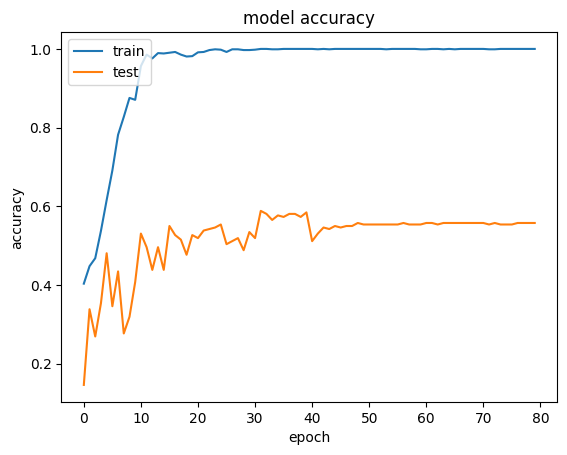

In [17]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 # history for loss

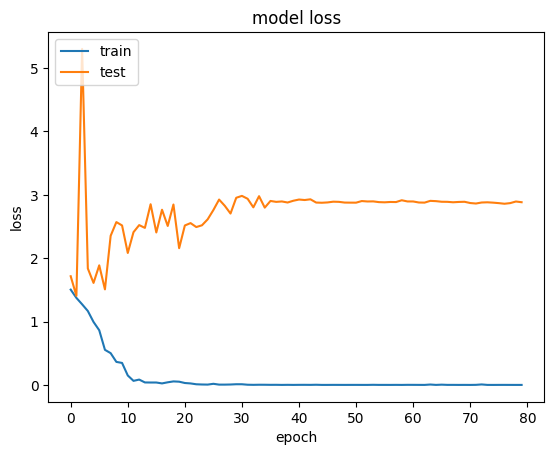

In [18]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
label_name

['Final AD JPEG',
 'Final CN JPEG',
 'Final EMCI JPEG',
 'Final LMCI JPEG',
 'Final MCI JPEG']

In [20]:
prediction=model.predict(X_test)

pred_label=np.argmax(prediction,axis=1)

y_pred=np.argmax(Y_test,axis=1)



9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


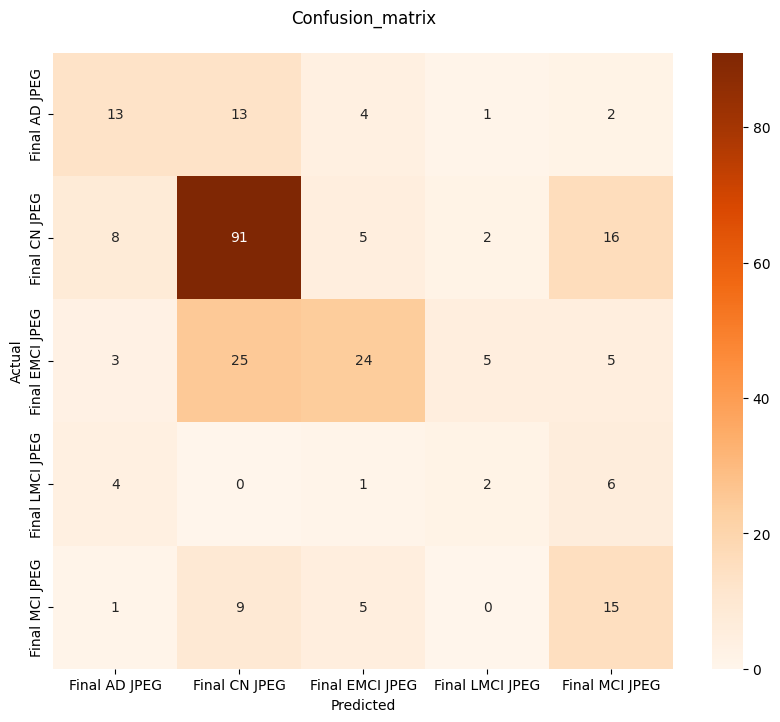

In [21]:
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_pred,pred_label)
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="Oranges",xticklabels=label_name,yticklabels=label_name)
plt.title("Confusion_matrix\n")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [22]:
print(classification_report(y_pred, pred_label,target_names=["Final AD JPEG" , "Final CN JPEG",  "Final EMCI JPEG","Final LMCI JPEG","Final MCI JPEG"]))

                 precision    recall  f1-score   support

  Final AD JPEG       0.45      0.39      0.42        33
  Final CN JPEG       0.66      0.75      0.70       122
Final EMCI JPEG       0.62      0.39      0.48        62
Final LMCI JPEG       0.20      0.15      0.17        13
 Final MCI JPEG       0.34      0.50      0.41        30

       accuracy                           0.56       260
      macro avg       0.45      0.44      0.43       260
   weighted avg       0.56      0.56      0.55       260



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


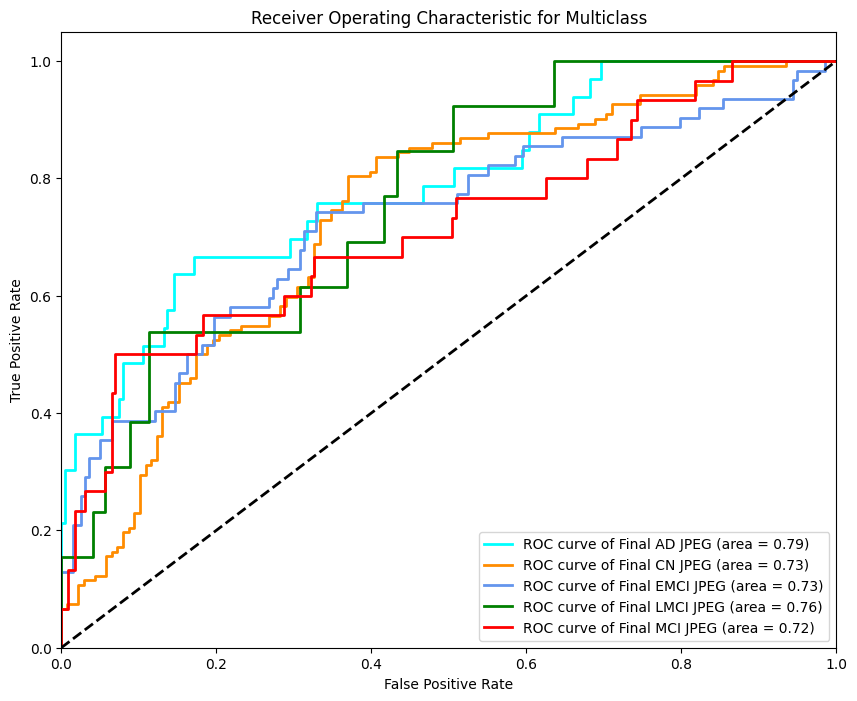

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Your class labels
class_names = ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']

# Assuming model is your trained Keras model
# Make predictions (probabilities)
Y_pred = model.predict(X_test)

# Binarize the output labels with the actual class names
Y_test_bin = label_binarize(Y_test, classes=class_names)
n_classes = Y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class
plt.figure(figsize=(10,8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


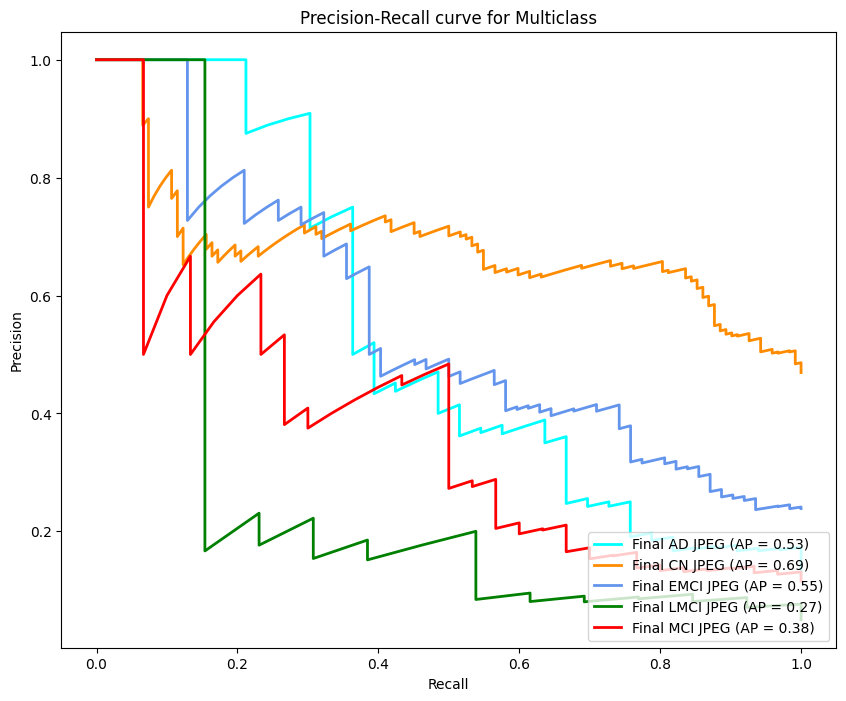

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Your class labels
class_names = ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']

# Assuming model is your trained Keras model
# Make predictions (probabilities)
Y_pred = model.predict(X_test)

# Binarize the output labels with the actual class names
Y_test_bin = label_binarize(Y_test, classes=class_names)
n_classes = Y_test_bin.shape[1]

# Compute Precision-Recall and average precision score for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test_bin[:, i], Y_pred[:, i])
    average_precision[i] = average_precision_score(Y_test_bin[:, i], Y_pred[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10,8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'{class_names[i]} (AP = {average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for Multiclass')
plt.legend(loc="lower right")
plt.show()


In [25]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss, cohen_kappa_score, matthews_corrcoef, log_loss

y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = Y_test.argmax(axis=1)

accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(Y_test, y_pred_probs, multi_class="ovo", average="weighted")

brier_scores = []
for i in range(y_pred_probs.shape[1]):
    brier = brier_score_loss(y_true == i, y_pred_probs[:, i])
    brier_scores.append(brier)
average_brier_score = np.mean(brier_scores)

kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
log_loss_value = log_loss(Y_test, y_pred_probs)

print("========================================================================")
print(f"Accuracy: {accuracy}")
print("========================================================================")
print(f"ROC AUC Score: {roc_auc}")
print("========================================================================")
print(f"Average Brier Score: {average_brier_score}")
print("========================================================================")
print(f"Cohen's Kappa Score: {kappa}")
print("========================================================================")
print(f"Matthews Correlation Coefficient: {mcc}")
print("========================================================================")
print(f"Log Loss Score: {log_loss_value}")
print("========================================================================")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Accuracy: 0.5576923076923077
ROC AUC Score: 0.7388958623212418
Average Brier Score: 0.1543210920045715
Cohen's Kappa Score: 0.34913689893119126
Matthews Correlation Coefficient: 0.35314174738024445
Log Loss Score: 2.874847242882928


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


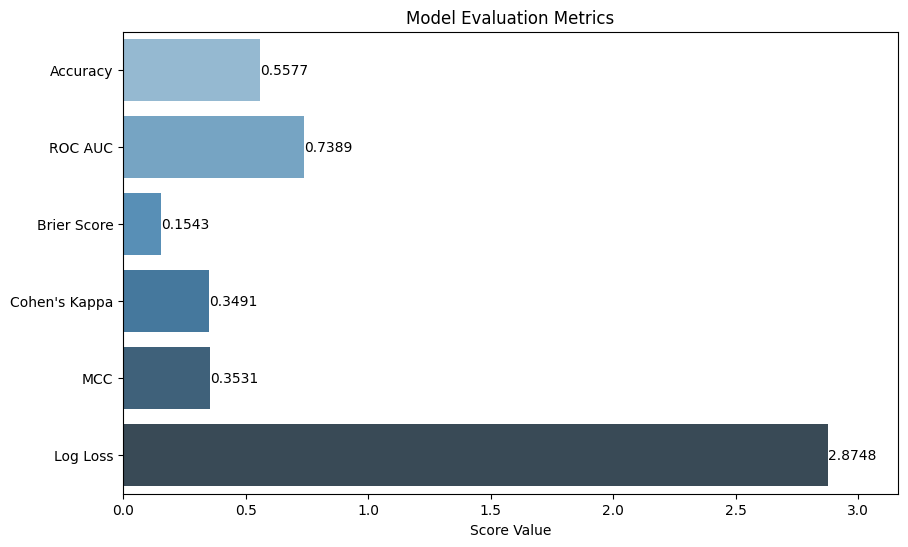

In [26]:

# Calculate metrics
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
y_true = Y_test.argmax(axis=1)

accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(Y_test, y_pred_probs, multi_class="ovo", average="weighted")

brier_scores = []
for i in range(y_pred_probs.shape[1]):
    brier = brier_score_loss(y_true == i, y_pred_probs[:, i])
    brier_scores.append(brier)
average_brier_score = np.mean(brier_scores)

kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
log_loss_value = log_loss(Y_test, y_pred_probs)

# Prepare data for plotting
scores = [accuracy, roc_auc, average_brier_score, kappa, mcc, log_loss_value]
score_names = ["Accuracy", "ROC AUC", "Brier Score", "Cohen's Kappa", "MCC", "Log Loss"]

# Create a seaborn bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=scores, y=score_names, palette="Blues_d")

# Annotate the bars with their values
for index, value in enumerate(scores):
    plt.text(value, index, f"{value:.4f}", va='center')

# Adjust x-axis to fit all scores, including Log Loss
plt.xlabel('Score Value')
plt.title('Model Evaluation Metrics')
plt.xlim(0, max(scores) * 1.1)  # Extend the x-axis slightly beyond the maximum score

plt.show()


In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Define class names
class_names = ['Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']

# Load and preprocess custom image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image
    return img_array

# Predict the class of the custom image
def predict_image_class(img_path, model, class_names):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    
    return predicted_class_name, confidence

# Example usage:
img_path = '/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/test/Final EMCI JPEG/ADNI_011_S_4547_MR_Axial_T2_STAR__br_raw_20170821092741965_22_S598928_I892712.jpg'
predicted_class_name, confidence = predict_image_class(img_path, model, class_names)

print(f"Predicted Class: {predicted_class_name} with confidence {confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Predicted Class: Final CN JPEG with confidence 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


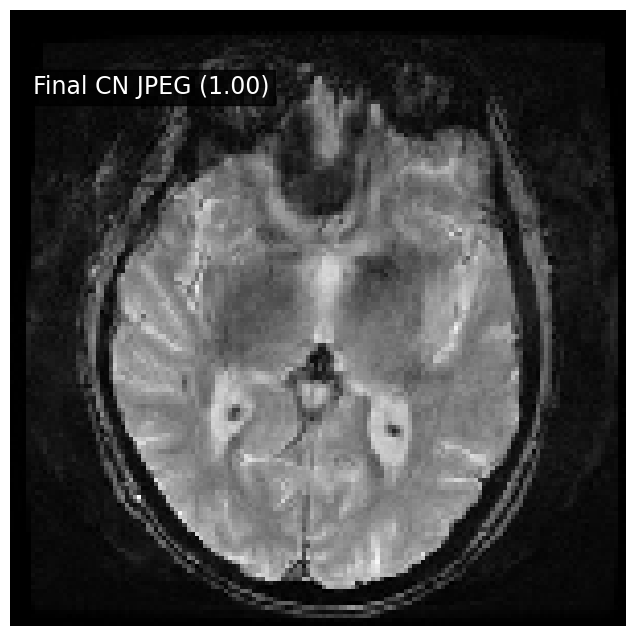

In [28]:


# Load and preprocess custom image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image
    return img_array

# Predict the class of the custom image
def predict_image_class(img_path, model, class_names):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    
    return predicted_class_name, confidence, img_array

# Plot image with predicted class name and confidence
def plot_prediction(img_path, model, class_names):
    predicted_class_name, confidence, img_array = predict_image_class(img_path, model, class_names)
    
    # Load the image for display (without preprocessing)
    img = image.load_img(img_path, target_size=(150, 150))
    plt.figure(figsize=(10,8))
    plt.imshow(img)
    plt.axis('off')
    
    # Display the class name and confidence on the image
    plt.text(5, 20, f"{predicted_class_name} ({confidence:.2f})", color='white', fontsize=17,
             bbox=dict(facecolor='black', alpha=0.8))
    
    plt.show()

# Example usage:
img_path = '/kaggle/input/alzheimersdisease5classdatasetadni/Alzheimers-ADNI/test/Final EMCI JPEG/ADNI_016_S_5007_MR_Axial_T2_Star__br_raw_20150227153131109_22_S250069_I475205.jpg'
plot_prediction(img_path, model, class_names)


# Data Prediction

In [29]:
def image_prediction(upload):
    for name, fileinfo in uploader.value.items():
        image_file=Image.open(io.BytesIO(fileinfo["content"]))
    predict_image=cv2.cvtColor(np.array(image_file),cv2.COLOR_RGB2BGR)
    predict_image=cv2.resize(predict_image,(150,150))
    predict_image=predict_image.reshape(1,150,150,3)
    predict_image=model.predict(predict_image)
    predict_image=np.argmax(predict_image,axis=1)[0]
    
    if predict_image==0:
        predict_image="Final AD JPEG"
    elif predict_image==1:
        predict_image="Final CN JPEG"
    elif predict_image==2:
        predict_image="Final EMCI JPEG"
    elif predict_image==3:
        predict_image="Final LMCI JPEG"
    elif predict_image==4:
        predict_image="Final MCI JPEG"
    
    if predict_image !=1:
        print(f"Model prediction is  {predict_image}")
    


In [30]:
uploader=widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [31]:
button=widgets.Button(description="Predict")
out_put=widgets.Output()

def button_click(_):
    with out_put:
        clear_output()
        try:
            image_prediction(uploader)
        except:
            print("Enter Correct Image File")

button.on_click(button_click)
widgets.VBox([button,out_put])